### Import Packages

In [1]:
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
from nltk.corpus import stopwords
from nltk import word_tokenize,ne_chunk,pos_tag
from nltk.util import ngrams
import itertools
import networkx as nx
from networkx.algorithms import community
% matplotlib notebook

### Load Data

In [2]:
all_data_store_path = '/Users/tylio/Google Drive/2018 spring/686/Wiley Sponsered Project/Data'
current_data_folder_name = '(40000+)_by_year'
current_data_store_path = os.path.join(all_data_store_path,current_data_folder_name)
data = pd.read_csv(os.path.join(current_data_store_path,'wholeFile_with_wholeTopic_v2_2.csv'))

//anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (2,3,4,6,7,10,40,48,50,55,56) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data.head()

,PT,AU,BA,BE,GP,AF,BF,CA,TI,SO,...,corrosion resistance,property,morphology,polymeric biomaterials,vitro,effect,biomedical application,emerging,shrinking,emergingAndShrinking
0,J,"Takahashi, Y; Ohkawa, K; Ando, M; Yamada, M; Y...",NaN,NaN,NaN,"Takahashi, Y; Ohkawa, K; Ando, M; Yamada, M; Y...",NaN,NaN,Adsorption of endocrine disruptors and related...,MACROMOLECULAR MATERIALS AND ENGINEERING,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
1,J,"Granja, PL; Pouysegu, L; Petraud, M; De Jeso, ...",NaN,NaN,NaN,"Granja, PL; Pouysegu, L; Petraud, M; De Jeso, ...",NaN,NaN,Cellulose phosphates as biomaterials. I. Synth...,JOURNAL OF APPLIED POLYMER SCIENCE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
2,J,"Granja, PL; Pouysegu, L; Deffieux, D; Daude, G...",NaN,NaN,NaN,"Granja, PL; Pouysegu, L; Deffieux, D; Daude, G...",NaN,NaN,Cellulose phosphates as biomaterials. II. Surf...,JOURNAL OF APPLIED POLYMER SCIENCE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0
3,J,"Jacoby, M",NaN,NaN,NaN,"Jacoby, M",NaN,NaN,Biomaterials - Tough bones,CHEMICAL & ENGINEERING NEWS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
4,J,"Arwin, H",NaN,NaN,NaN,"Arwin, H",NaN,NaN,Spectroscopic ellipsometry for characterizatio...,PHYSICA STATUS SOLIDI A-APPLIED RESEARCH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Barcharts for Top Authors or Topics

In [5]:
def barcharts_for_author(df,year_from,year_to,top_n):
    
    data_range = df[(df['PY']>=year_from)&(df['PY']<=year_to)&(df['AF'].notnull())&(df['AF']!='[Anonymous]')]
    total_documents = data_range.shape[0]
    author_list = data_range['AF'].str.split('; ')
    author_dict = dict()
    for authors in author_list:
        for i in authors:
            lower_name = i.lower().title()
            author_dict[lower_name] = author_dict.get(lower_name,0)+1
    top_authors = sorted(author_dict,key = author_dict.get,reverse = True)[:top_n]
    top_author_scores_num = [author_dict[j] for j in top_authors]
    top_author_scores_percent = [k/total_documents for k in top_author_scores_num]
    top_author_df = pd.DataFrame({'Author_Name':top_authors,'Scores(percent)':top_author_scores_percent,'Scores(num)':top_author_scores_num})
    return top_author_df

In [8]:
def extract_topics_from_vosviewer_map(whole_file,year_from,year_to,top_n):
    
    all_data_store_path = '/Users/tylio/Google Drive/2018 spring/686/Wiley Sponsered Project/Data'
    current_data_folder_name = '5_period_occ(10plus)_rel(60%)'
    #current_data_folder_name = 'title top 5'
    current_data_store_path = os.path.join(all_data_store_path,current_data_folder_name)
    current_data_name = str(year_from)+'-'+str(year_to)+'_map.txt'
    topic_file = []
    current_df = pd.read_table(os.path.join(current_data_store_path,current_data_name),sep = '\t')
    total_documents = data[(data['PY']>=year_from)&(data['PY']<=year_to)].shape[0]

    top_topics = current_df.sort_values(by = 'weight<Occurrences>',ascending = False)[:top_n]
    top_topics_df = pd.DataFrame()
    top_topics_scores_num = top_topics['weight<Occurrences>']
    top_topics_scores_percent = [k/total_documents for k in top_topics_scores_num]
    top_topics_df = pd.DataFrame({'Topic_Name':top_topics['label'],'Scores(percent)':top_topics_scores_percent,'Scores(num)':top_topics_scores_num})
    top_topics_df = top_topics_df.reset_index()
    return top_topics_df#list(set(topic_file))

In [6]:
def plot_barcharts(df,year_from,year_to,top_n,theme = 'author'):
    if theme == 'author':
        chart_data = barcharts_for_author(df,year_from,year_to,top_n)
        name = 'Author_Name'
        title = 'Top {} Authors on Number/(Percentage) of Documents Published from {} to {}'.format(top_n,year_from,year_to)
    if theme == 'topic':
        chart_data = extract_topics_from_vosviewer_map(df,year_from,year_to,top_n)
        name = 'Topic_Name'
        title = 'Top {} Topics on Number/(Percentage) of Documents Published from {} to {}'.format(top_n,year_from,year_to)
    plt.figure(figsize = (10,6))
    plt.barh(range(len(chart_data)),chart_data['Scores(num)'])
    a = plt.gca()
    a.invert_yaxis()
    a.set_yticks(range(len(chart_data)))
    a.set_yticklabels(chart_data[name])
    plt.xlabel('Number/(Percentage) of Documents Published')
    plt.xlim((0,round(chart_data['Scores(num)'].max()*1.1,-1)))
    #plt.ylabel('Author Names')
    #a.set_xticklabels(['{:.2%}'.format(i) for i in chart_data['Scores(percent)']])
    plt.title(title,fontsize = 15)
    for i in range(len(chart_data)):
        x_co1 = a.patches[i].get_width()
        x_co2 = a.patches[i].get_width()-1
        y_co = a.patches[i].get_y()+a.patches[i].get_height()/2
        a.text(x = x_co1,y = y_co,s = '({:.2%})'.format(chart_data['Scores(percent)'][i]),ha = 'left',va = 'center')
        a.text(x = x_co2,y = y_co,s = chart_data['Scores(num)'][i],ha = 'right',va = 'center',color = 'white')
    plt.tight_layout()
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)

### Top10 Topics in Different Time Stage

<IPython.core.display.Javascript object>


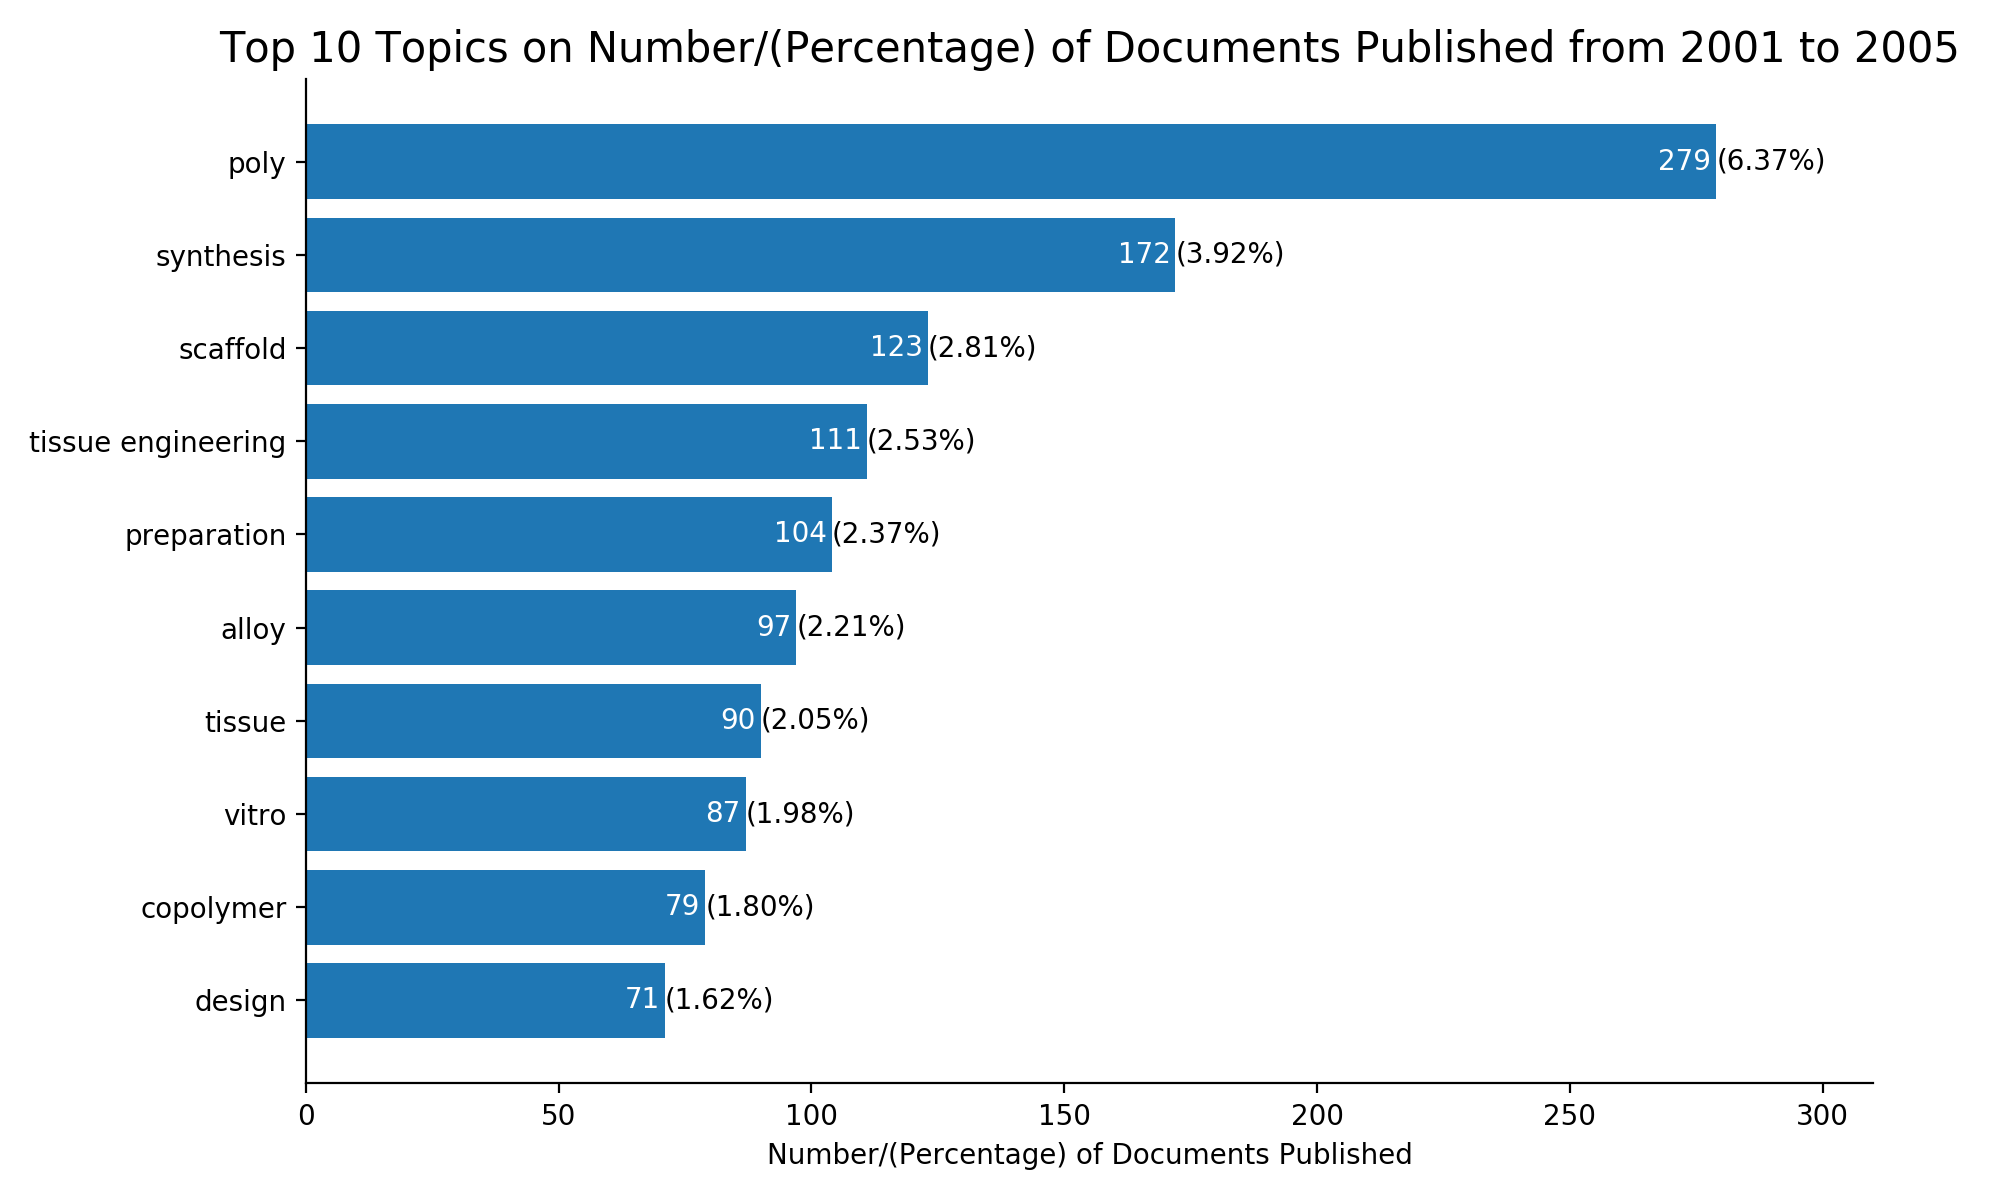

In [10]:
plot_barcharts(data,2001,2005,10,theme = 'topic')

<IPython.core.display.Javascript object>


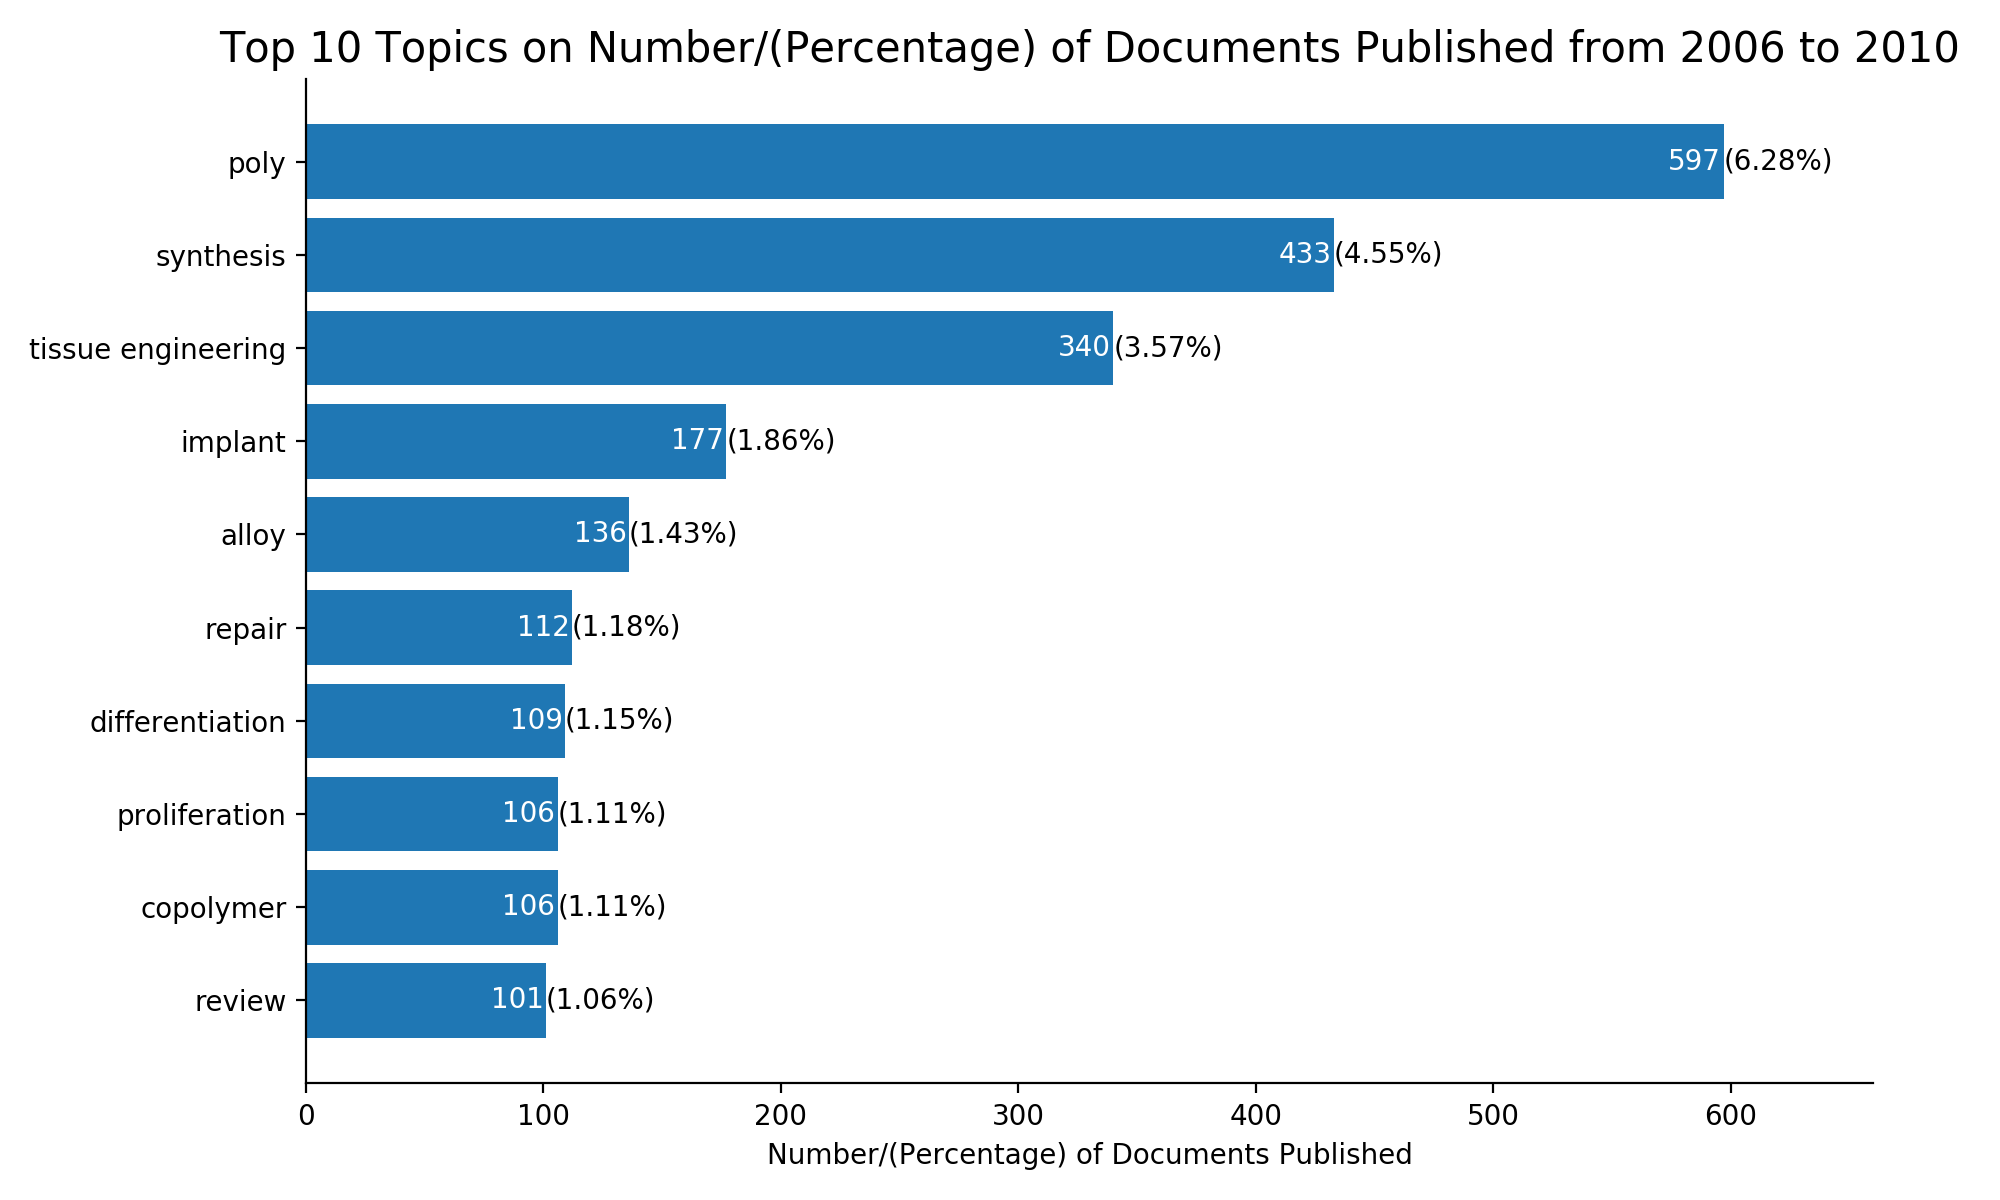

In [11]:
plot_barcharts(data,2006,2010,10,theme = 'topic')

<IPython.core.display.Javascript object>


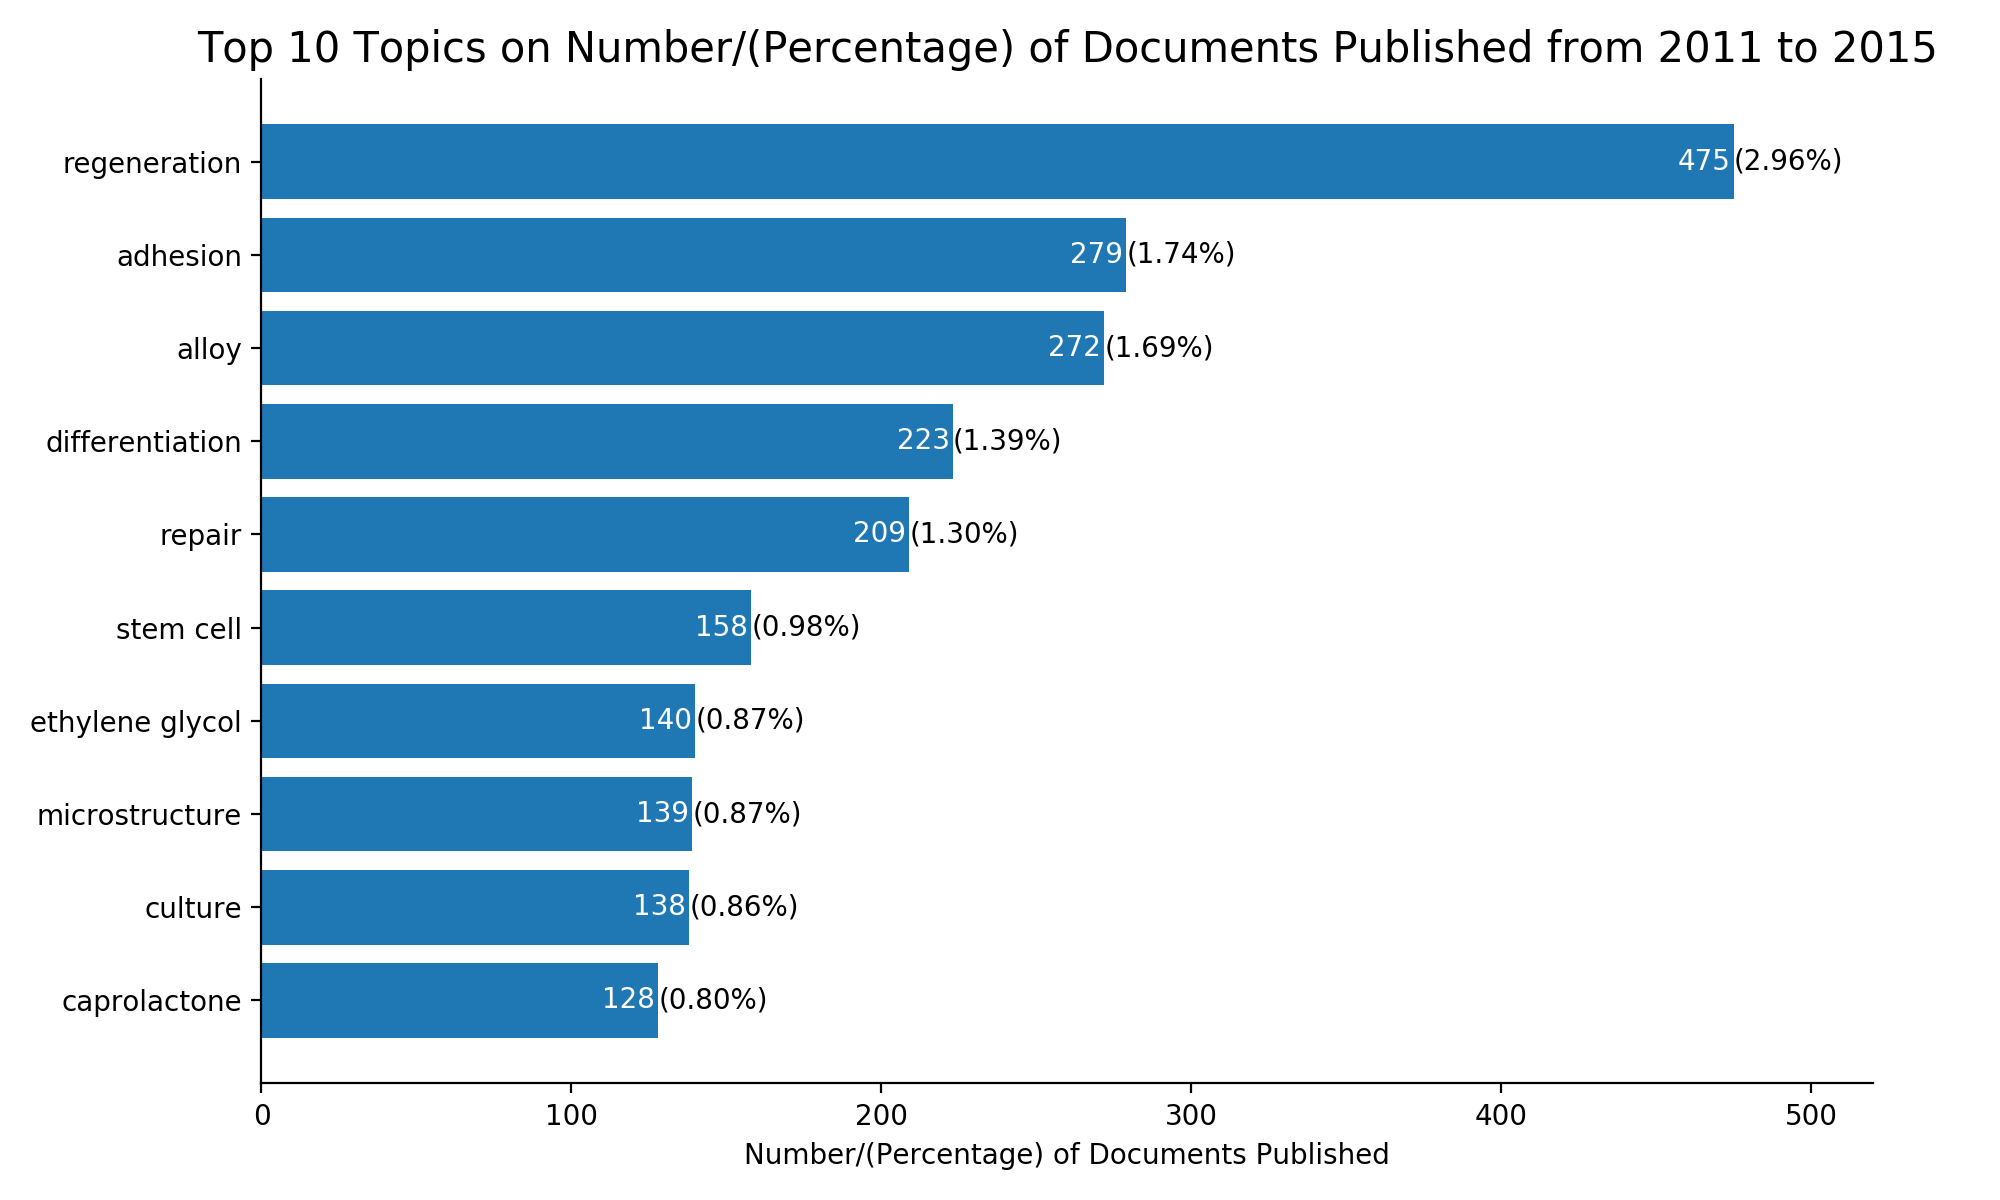

In [12]:
plot_barcharts(data,2011,2015,10,theme = 'topic')

<IPython.core.display.Javascript object>


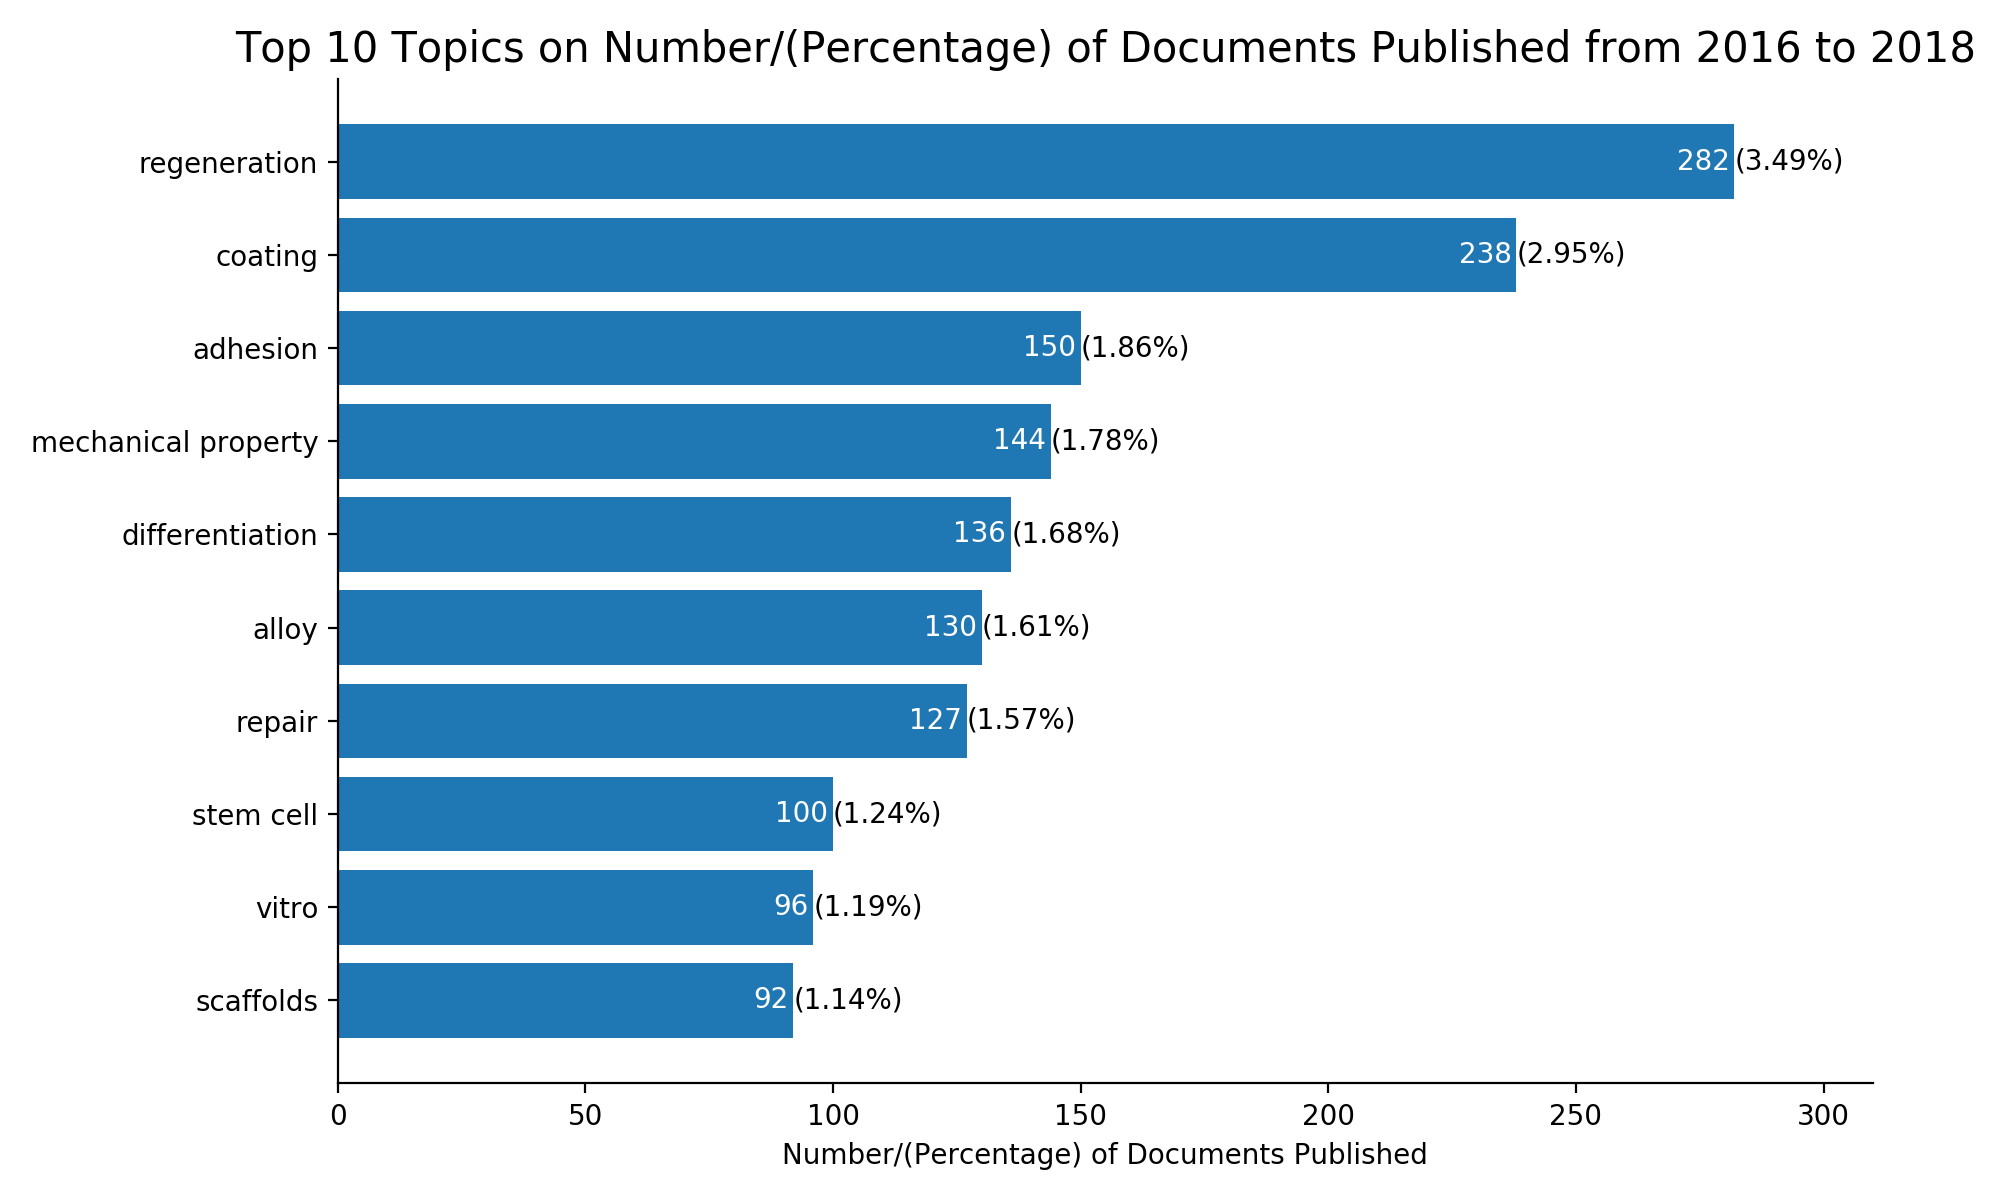

In [13]:
plot_barcharts(data,2016,2018,10,theme = 'topic')

### Top10 Authors in Different Time Stage

<IPython.core.display.Javascript object>


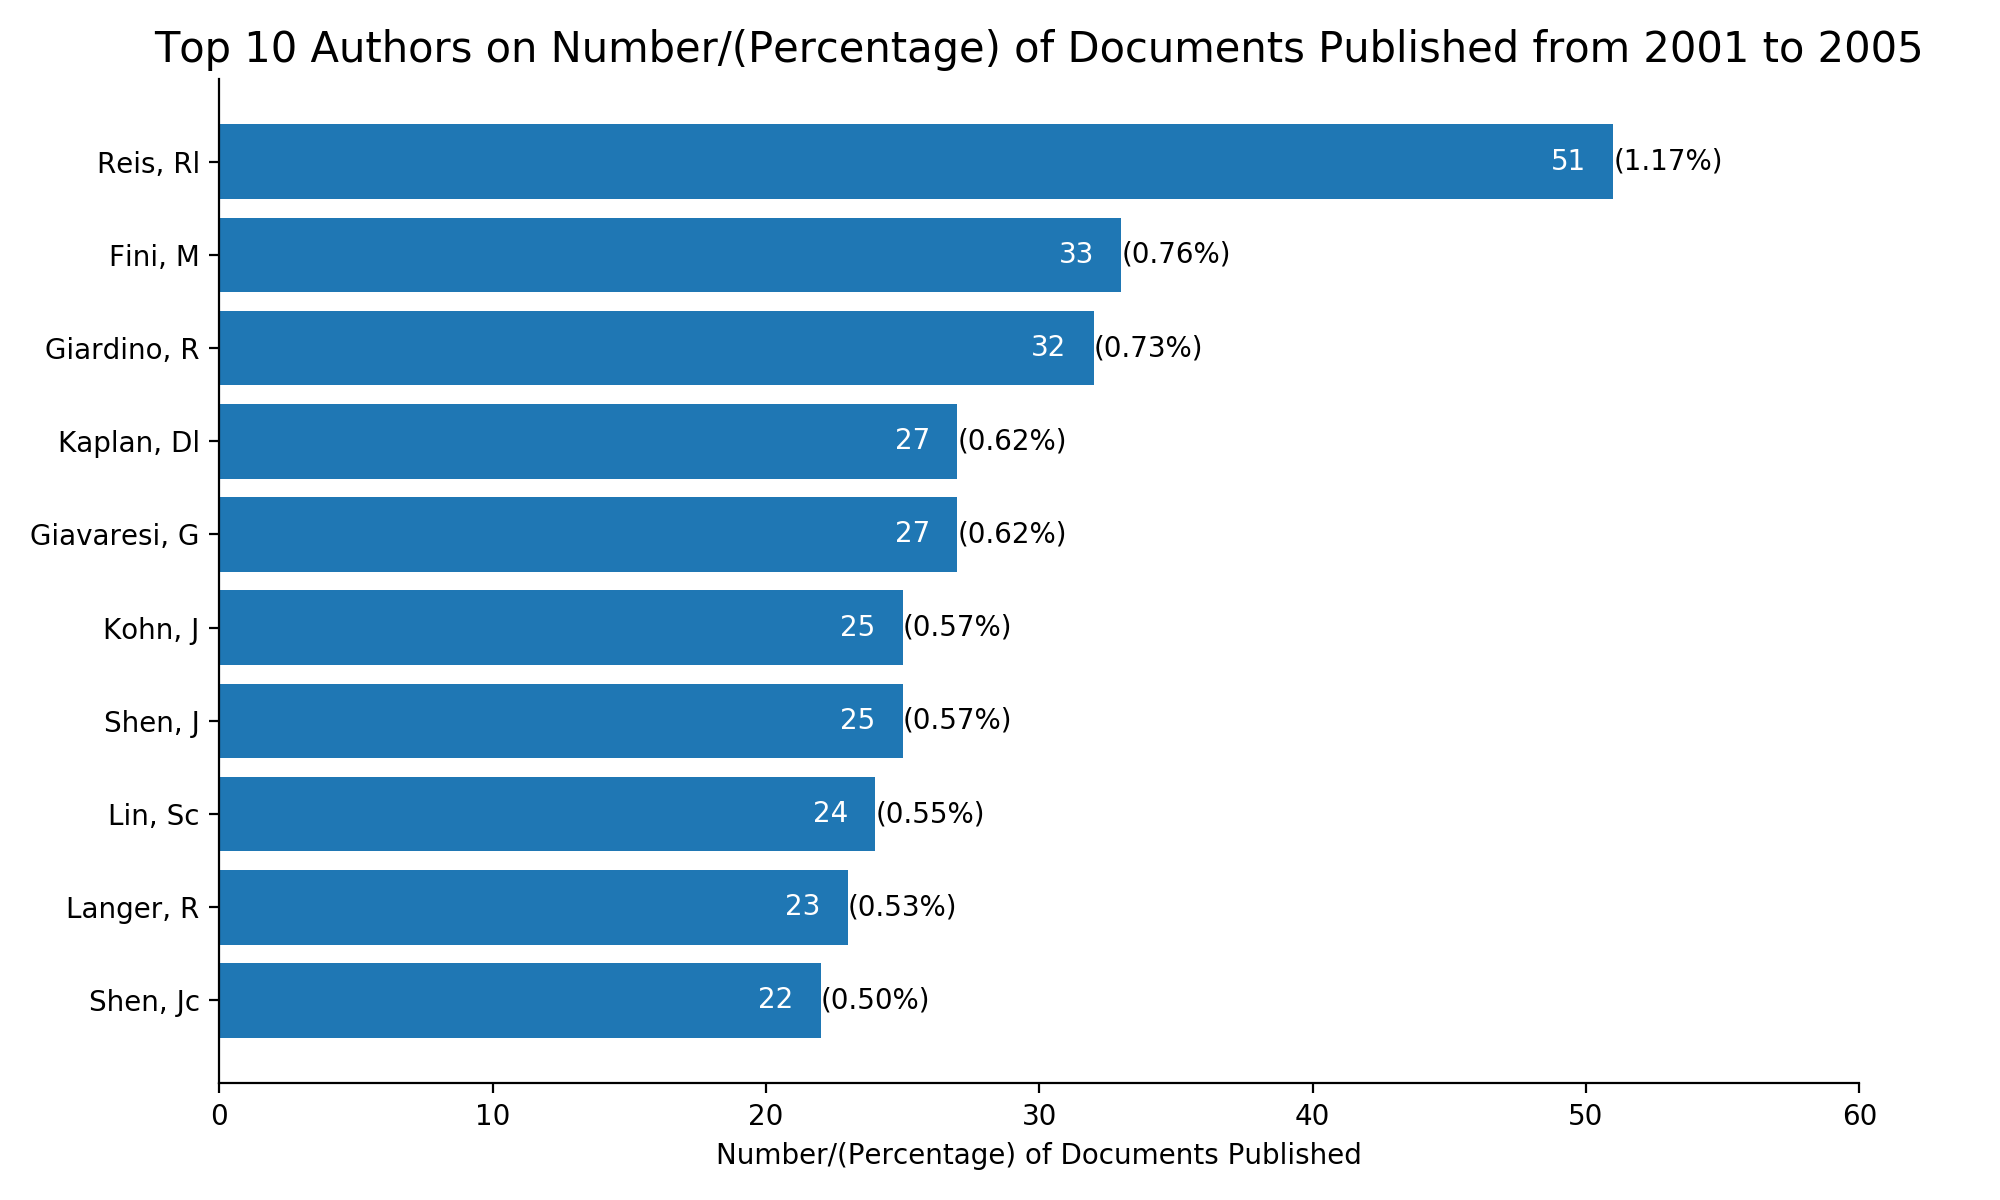

In [14]:
plot_barcharts(data,2001,2005,10,theme = 'author')

<IPython.core.display.Javascript object>


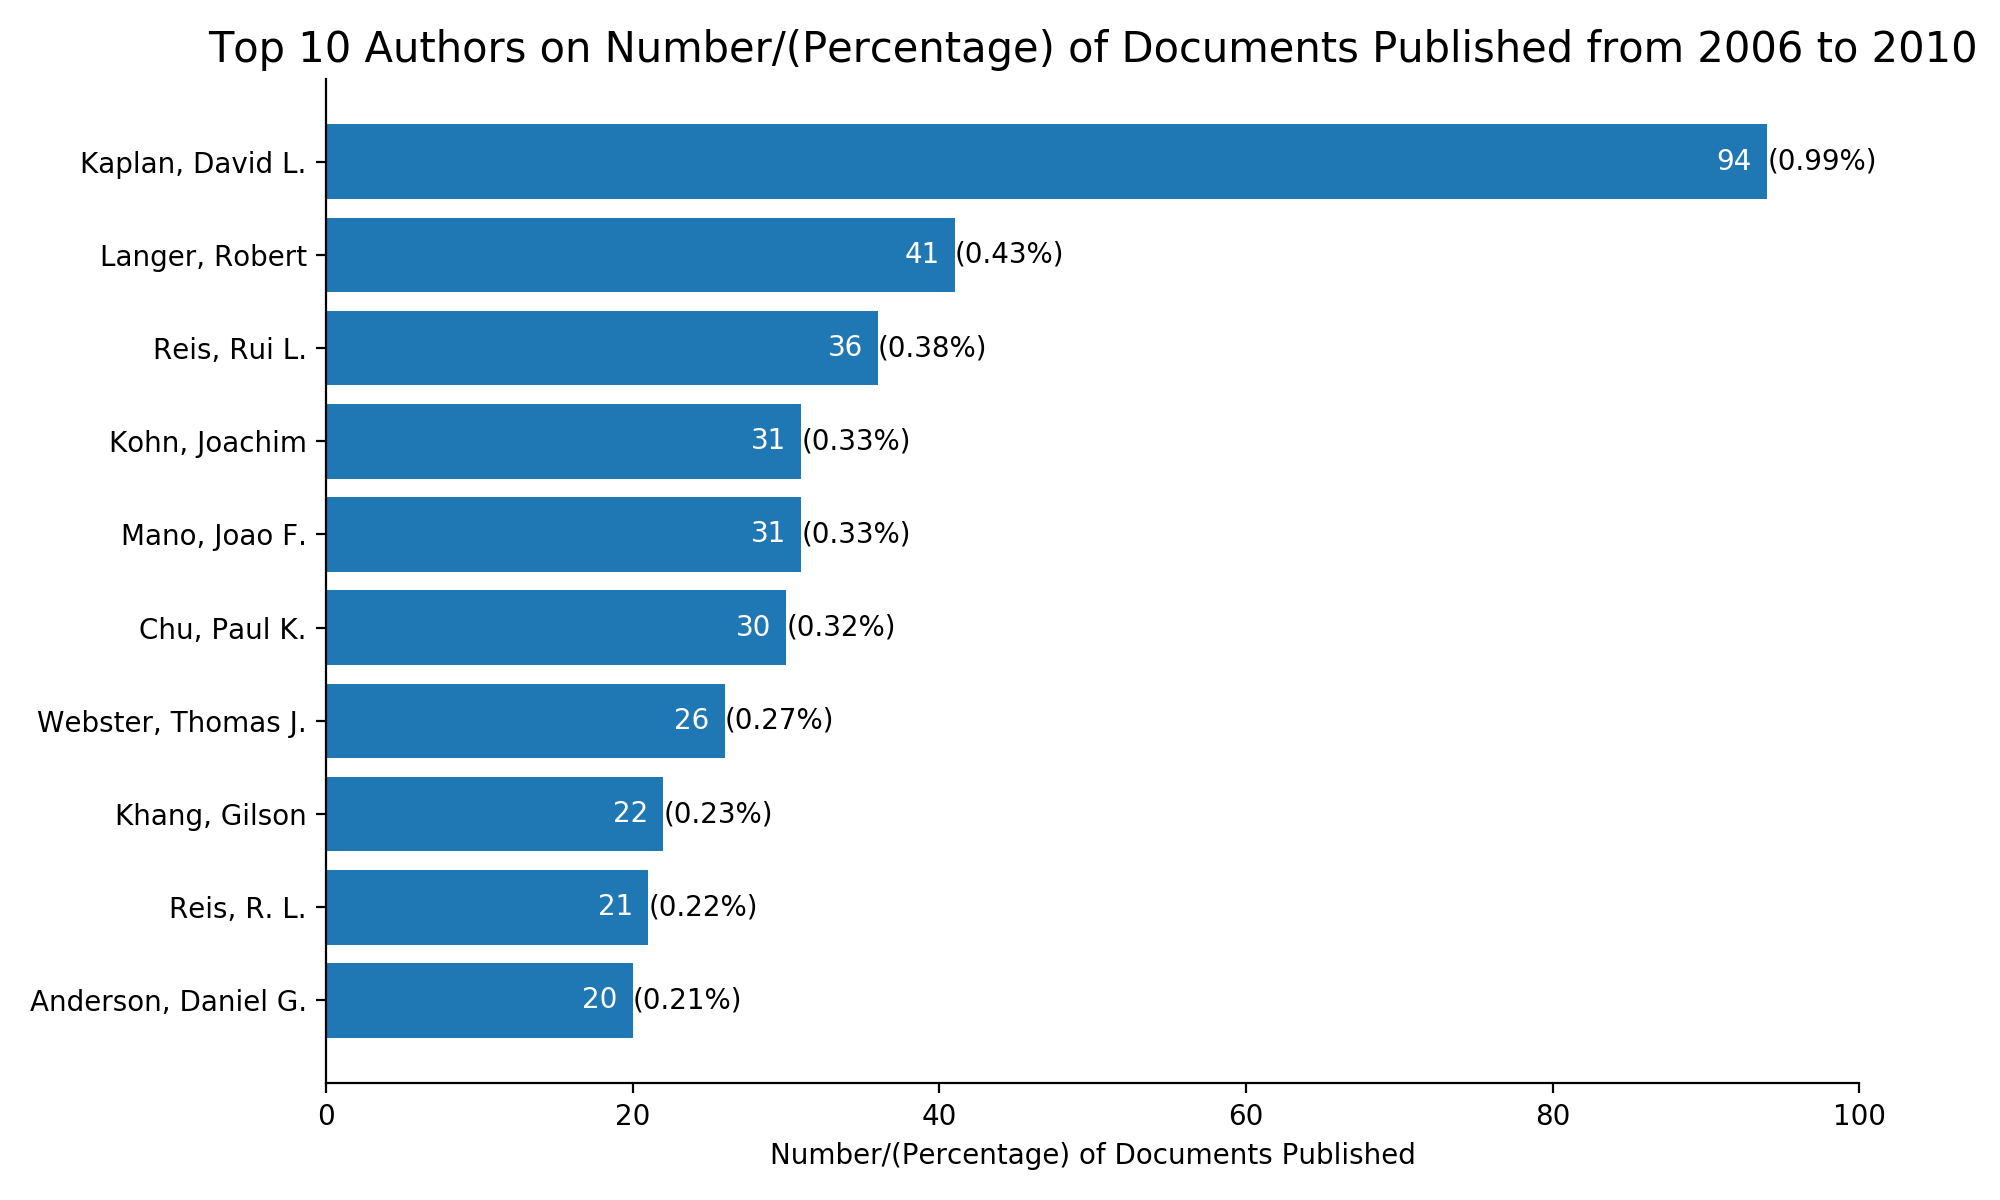

In [15]:
plot_barcharts(data,2006,2010,10,theme = 'author')

<IPython.core.display.Javascript object>


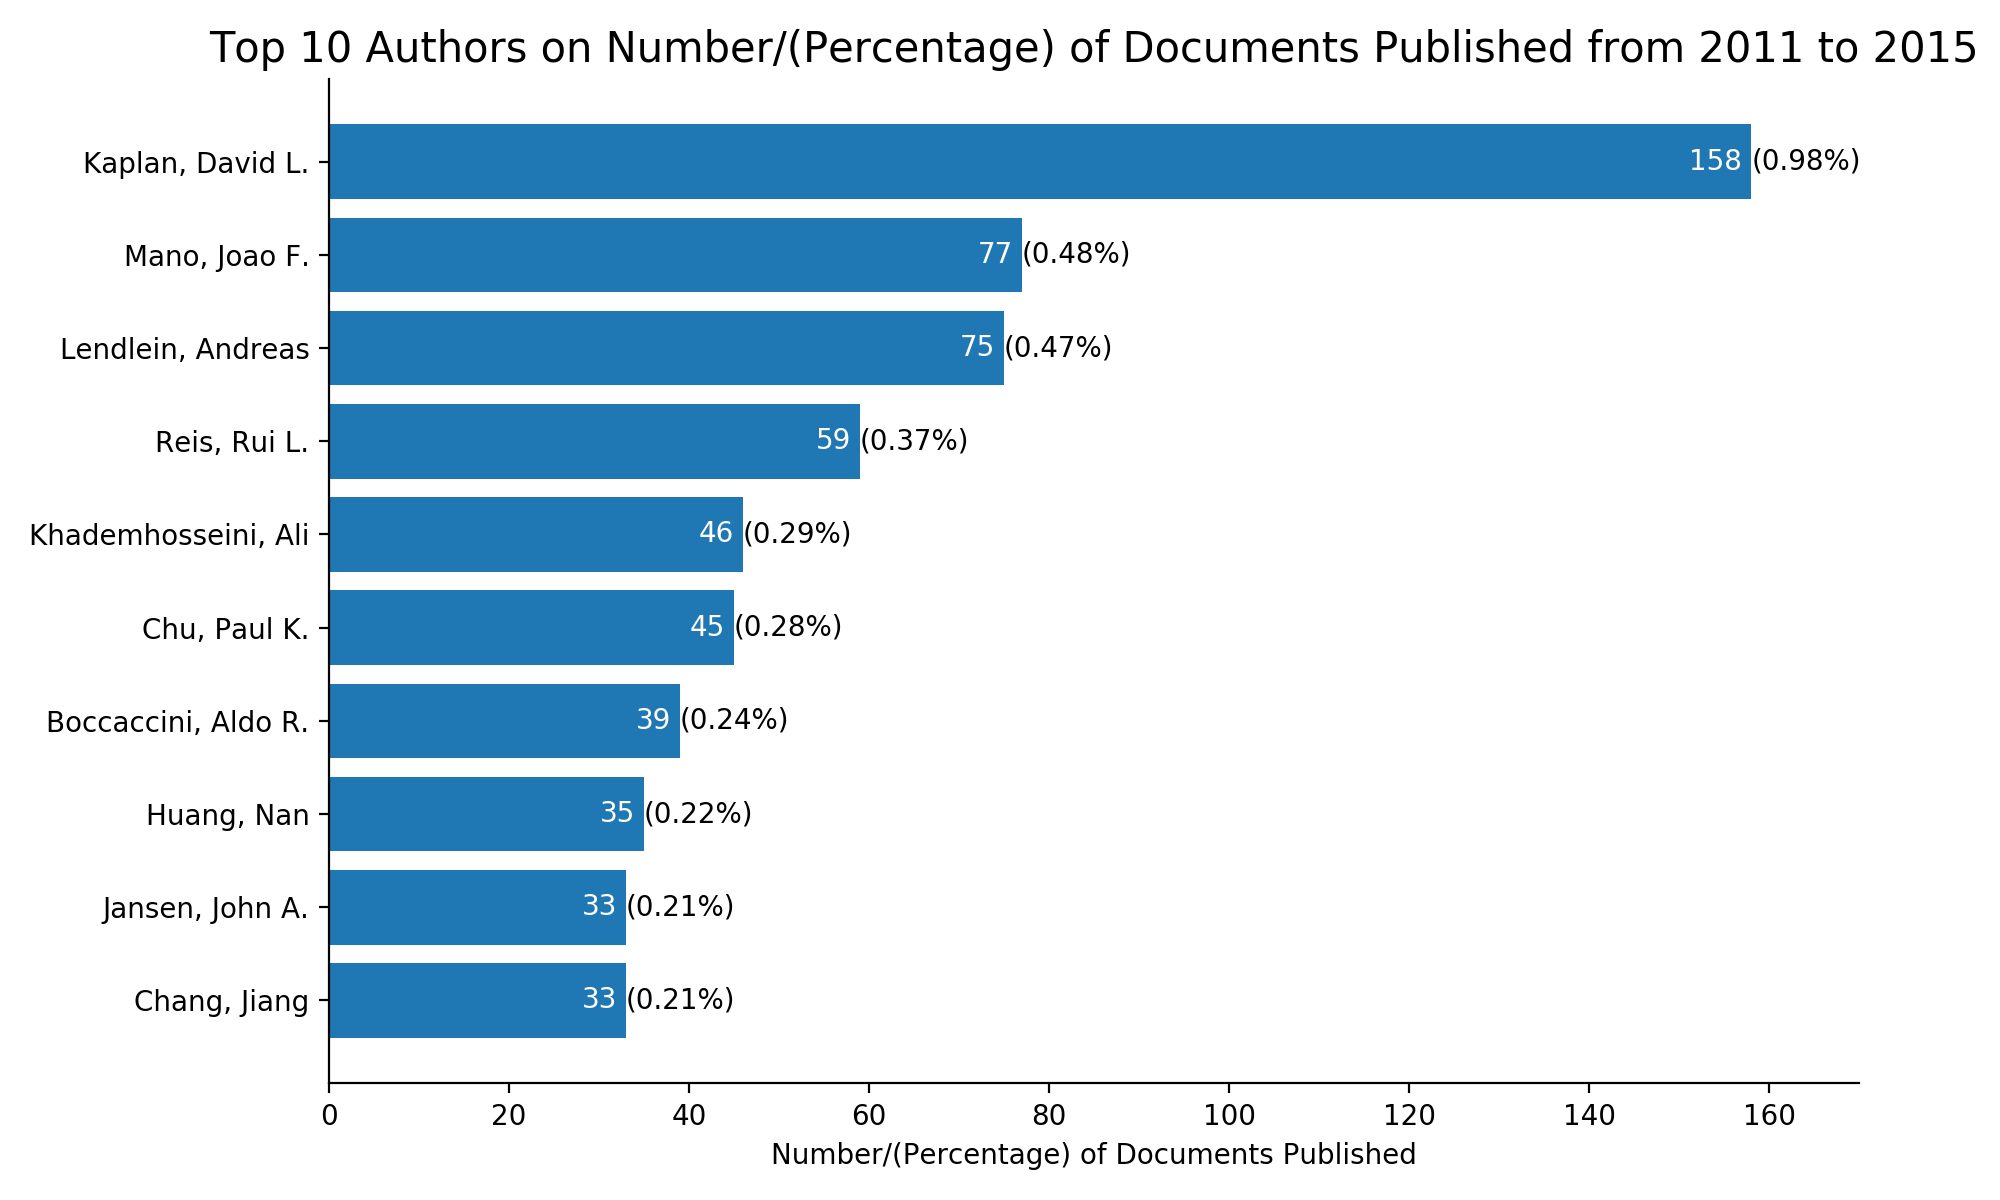

In [16]:
plot_barcharts(data,2011,2015,10,theme = 'author')

<IPython.core.display.Javascript object>


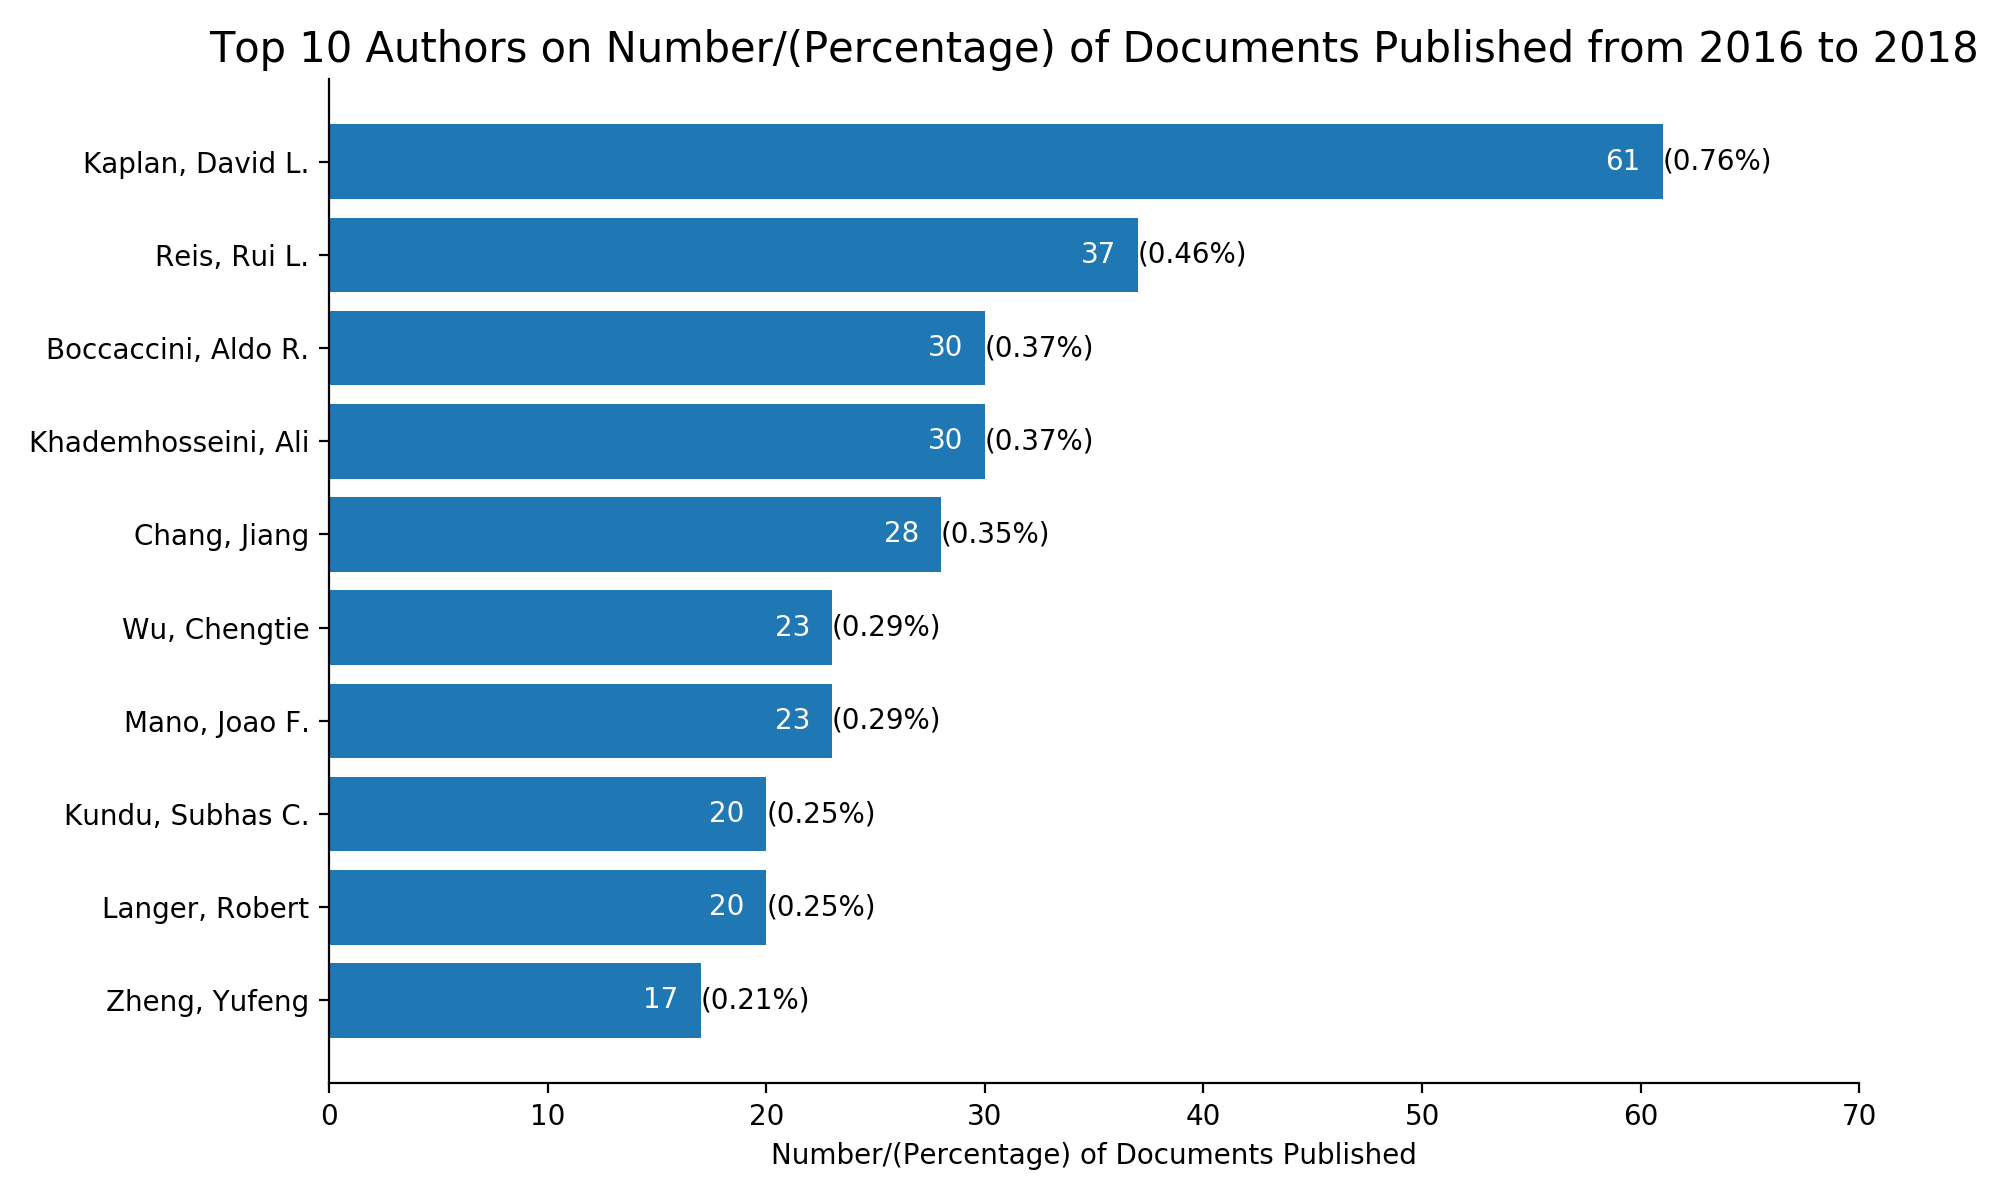

In [17]:
plot_barcharts(data,2016,2018,10,theme = 'author')

### Explore Several Topics

In [25]:
def trends_for_topic(topiclist):
    cmap = plt.get_cmap('Spectral')
    colors = [cmap(i) for i in np.linspace(0.8, 1, len(topiclist))]
    plt.figure(figsize = (10,6))
    for i in range(len(topiclist)):
        column = topiclist[i]#+'_subcat'
        percentage = pd.concat([data.groupby('PY')[column].count(),data.groupby('PY')['DA'].count()],axis = 1)
        percentage.loc[:,'percentage'] = percentage.apply(lambda x: x[column]/(x['DA']+0.00000001),axis = 1)
        ax = percentage[percentage.index>=1950]['percentage'].plot(linewidth = 3,label = topiclist[i])#,colors = colors[i])
    ax.set_title("Trends of Topics over Time Stage",fontsize = 15)
    ax.set_xlim(1999,2018)
    ax.grid(axis = 'x')
    ax.set_yticklabels(['{:3.0f}%'.format(i*100) for i in ax.get_yticks()])
    ax.set_xlabel('Publication Year',fontsize = 15)
    ax.set_ylabel('Percentage of Related Documents',fontsize = 15)
    plt.legend(fontsize = 15)

<IPython.core.display.Javascript object>


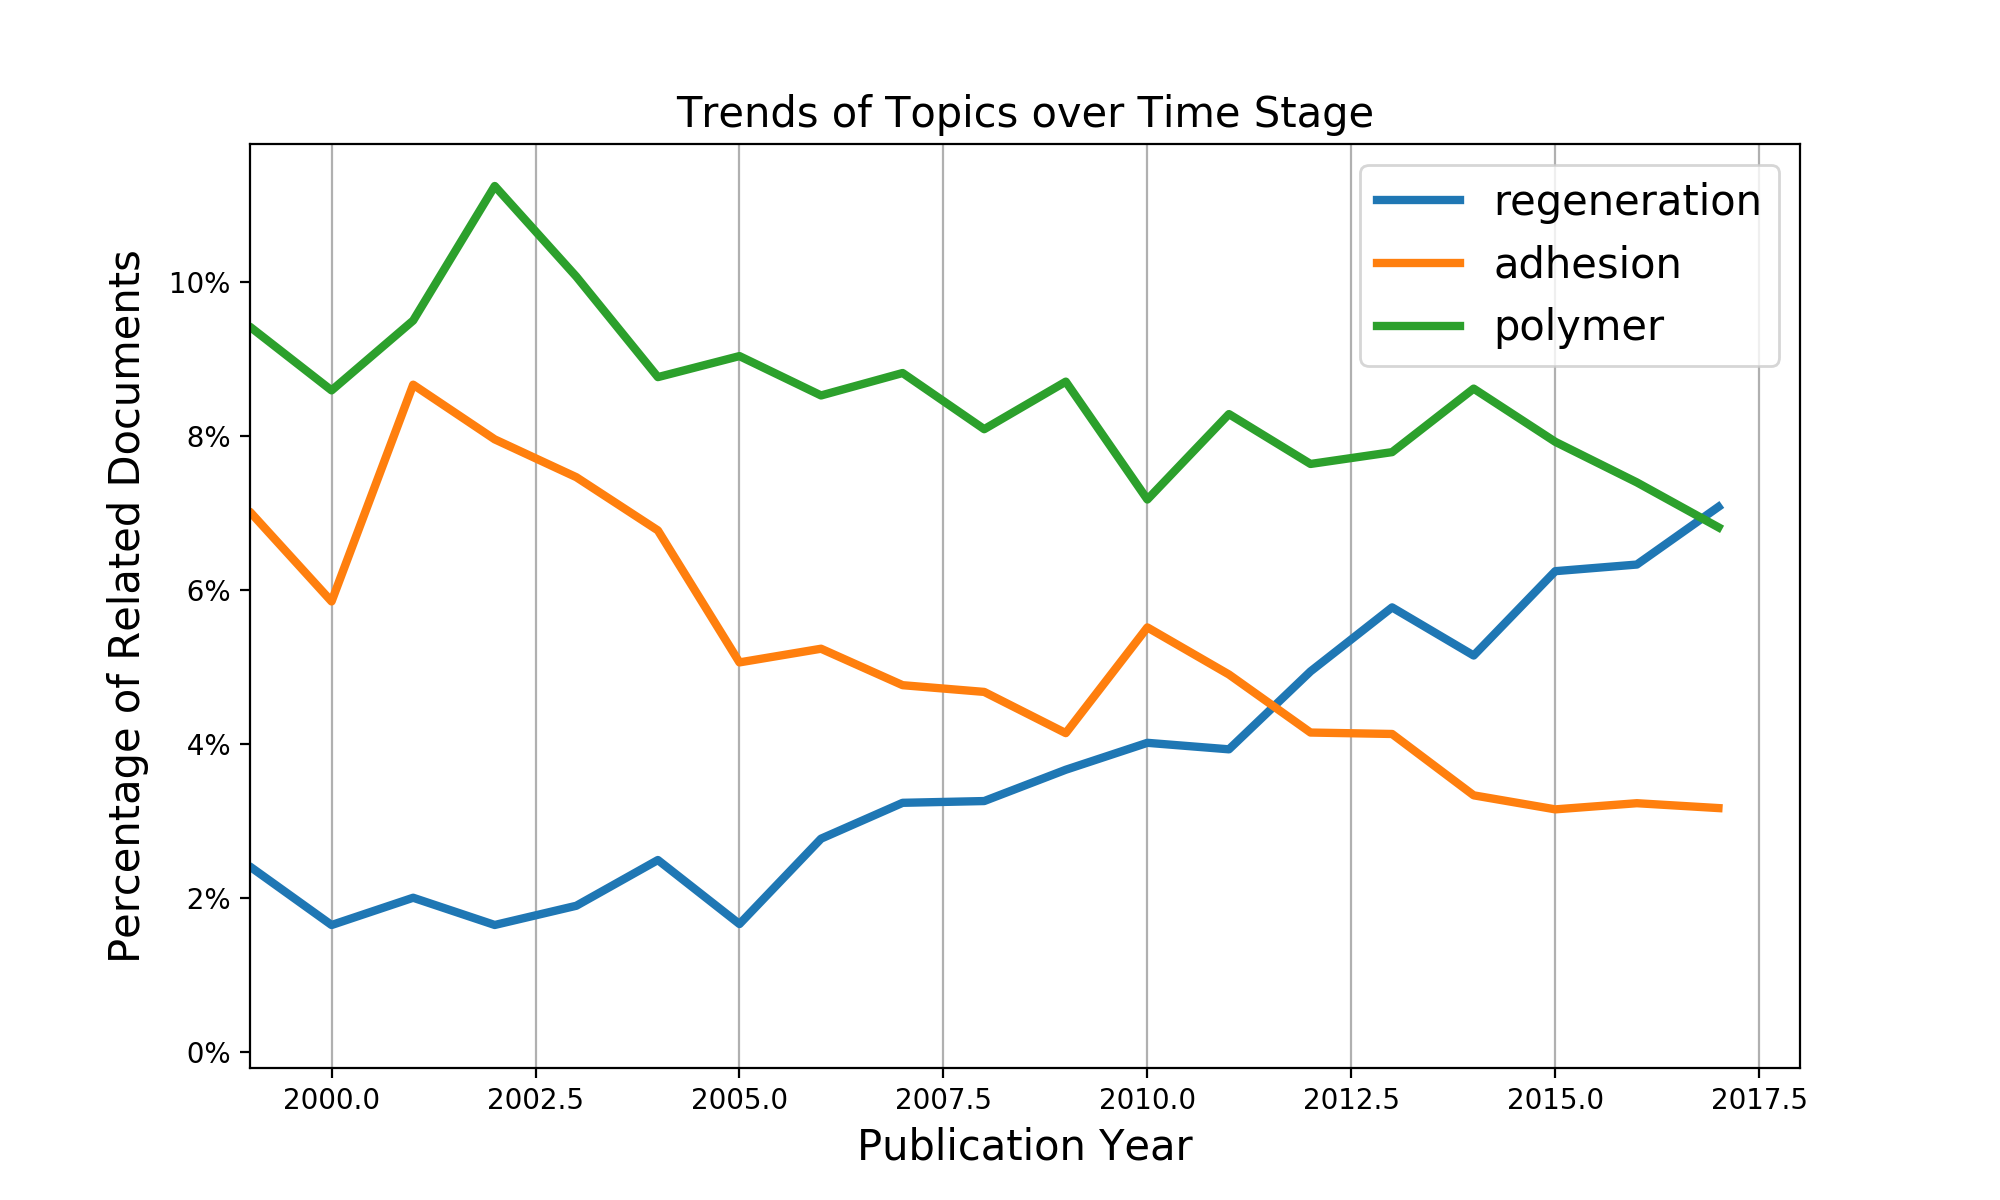

In [26]:
trends_for_topic(['regeneration','adhesion','polymer'])

Regeneration is an emerging topic where Polymer and Adhesion are shrinking topics.

### Compare Different Topics in Document Type

In [22]:
def compare_topics_in_document_type(topiclist,colorlist,space = 0.3,width = 0.8):
    columnlist = [i for i in topiclist]
    compare = pd.DataFrame()
    for i in columnlist:
        cat = data[data[i].notnull()]
        compare = pd.concat([compare,cat['DT'].rename(i).value_counts()],axis = 1)
#     data1 = data[data[column1].notnull()]
#     data2 = data[data[column2].notnull()]
#     compare12 = pd.concat([data1['DT'].rename('DT1').value_counts(),data2['DT'].rename('DT2').value_counts()],axis = 1)
    compare = compare.fillna(0).sort_values(columnlist[0],ascending = False)
    compare = compare.loc[['Article', 'Review', 'Proceedings Paper', 'Meeting Abstract',
       'Article; Proceedings Paper', 'Editorial Material',
       'Review; Book Chapter', 'Article; Book Chapter'],:]
    for i in compare.columns:
        total_num = compare[i].sum()
        compare.loc[:,i] = compare[i]/total_num
    plt.figure(figsize = (10,6))
    
    bar_loc_num = compare.shape[0]
    for i in range(len(columnlist)):
        if i ==0:
            loc = [j*(len(columnlist)*width+space) for j in range(bar_loc_num)]
        else:
            loc = [i+width for i in loc]
        plt.bar(loc,compare[compare.columns[i]],alpha = 0.6,width = width,label = topiclist[i])#,color = colorlist[i])
    ax = plt.gca()
    plt.ylim((0,1))
    ax.set_xticks([i+((len(columnlist)-1)*width)/2 for i in [j*(len(columnlist)*width+space) for j in range(bar_loc_num)]])
    ax.set_xticklabels(compare.index,rotation = 90)
    ax.set_yticklabels(['{:3.0f}%'.format(i*100) for i in ax.get_yticks()])
    plt.title('Document Type Distribution Compare',fontsize = 15)
    plt.ylabel('Percentage of Document Type',fontsize = 15)
    plt.legend(fontsize = 15)
    plt.tight_layout()

In [23]:
plt.rcParams['axes.prop_cycle'].by_key()['color']
b = '#1f77b4'
o = '#ff7f0e'
g = '#2ca02c'

<IPython.core.display.Javascript object>


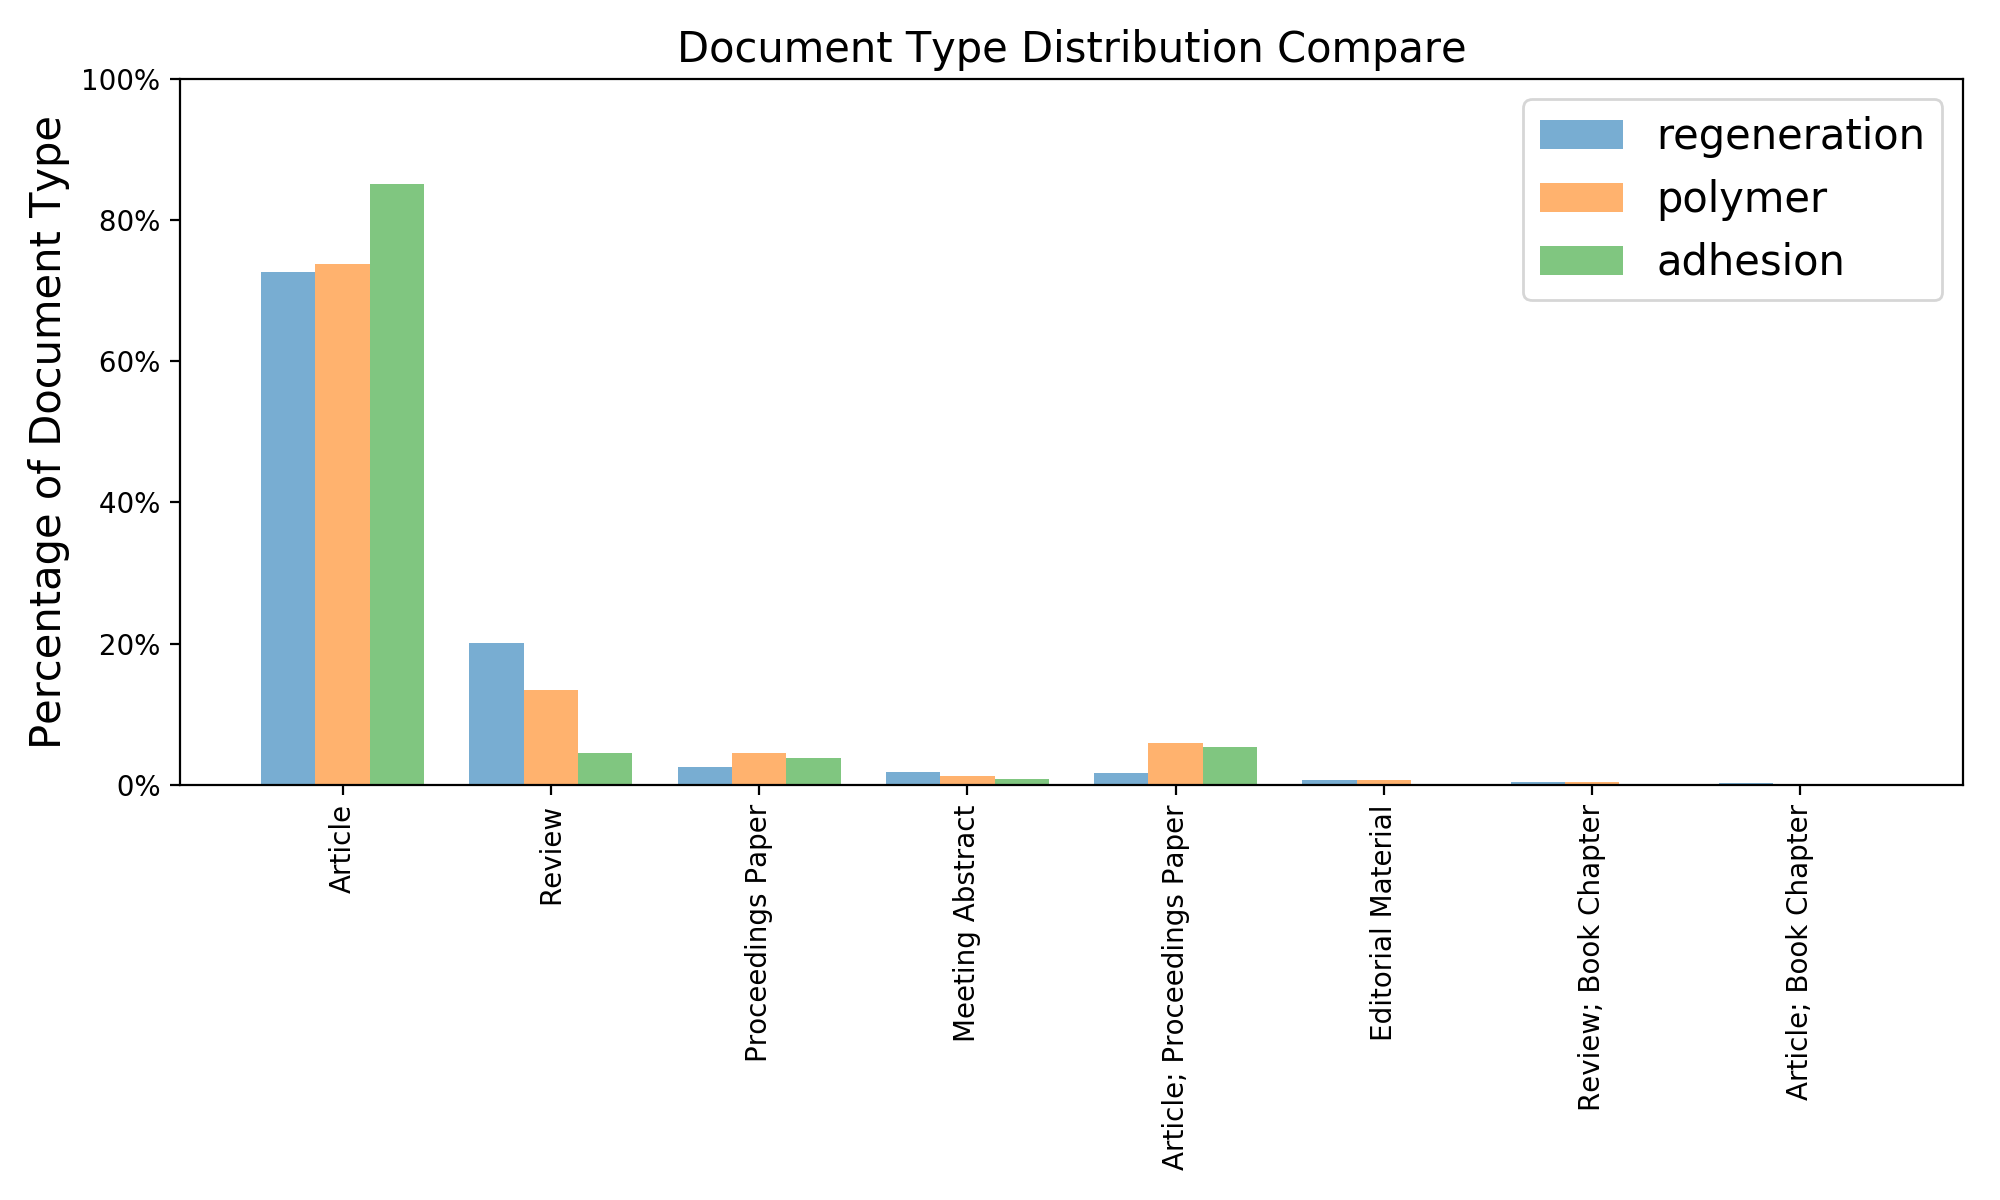

In [24]:
compare_topics_in_document_type(['regeneration','polymer','adhesion'],[g,b,o],space = 0.5,width = 0.6)